In [ ]:
# !pip install rdkit
# !pip install deepchem
# !pip install pysmiles
# !pip install networkx
# !pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.8 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=38b9c5d921b0e868ee2821286b0e3ec8224f9bc9455261b3337433a23d944c6b
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [ ]:
# import deepchem as dc
# from rdkit import Chem
# from deepchem.feat.mol_graphs import ConvMol
# from pysmiles import read_smiles
# import mordred

import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
data = pd.read_csv('tox21_dataset.csv')

In [ ]:
data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,...,JGI1,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,0,0,1,0,0,0,0,1,0,0,...,0.294118,0.080000,0.047033,0.065741,0.030258,0.034970,0.022428,0.018519,0.000000,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0.156250,0.090909,0.077336,0.040340,0.028333,0.015334,0.017795,0.020408,0.000000,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,0.208333,0.128655,0.058554,0.047859,0.032558,0.026715,0.020712,0.012766,0.010313,0.012346
3,0,0,0,0,0,0,0,0,0,0,...,0.200000,0.111111,0.060417,0.043218,0.022500,0.021380,0.012336,0.010408,0.006875,0.012346
4,0,0,0,0,0,0,0,0,0,0,...,0.600000,0.185185,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# **PCA model Building**

In [ ]:
# Androgen Receptor task
TOX21_TASKS = ['NR-AR']
task_data = data.iloc[:, 0:1]
feature_data = data.iloc[:, 14:]

In [ ]:
# normalize data
scaler = StandardScaler()
feature_data_normal = scaler.fit_transform(feature_data)

In [ ]:
from joblib import dump, load
dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
from sklearn.decomposition import PCA

myPca = PCA()

myPca.fit(feature_data_normal)

var = myPca.explained_variance_ratio_

In [ ]:
feature_data_pca = myPca.transform(feature_data_normal)
# feature_data_pca.head()

In [ ]:
feature_data_pca = feature_data_pca[:,:30]

In [ ]:
print(task_data.shape)
print(feature_data_pca.shape)
#split the data into training and test data
features_train, features_test, task_train, task_test = train_test_split(feature_data_pca, task_data, test_size=0.20, random_state=42)

(7831, 1)
(7831, 30)


In [ ]:
task_train.value_counts()

,count
NR-AR,
0,6016
1,248


In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy=0.5)  # Adjust the ratio
# features_train, task_train = smote.fit_resample(features_train, task_train)

# task_train.value_counts()


In [ ]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

# y contains the class labels (0s and 1s) for the binary classification problem
class_weights = calculate_class_weights(task_train)
print("Class weights:", class_weights)

Class weights: {0: 0.5206117021276596, 1: 12.629032258064516}


In [ ]:
features_train = np.array(features_train)
task_train = np.array(task_train)

features_test = np.array(features_test)
task_test = np.array(task_test)

print(type(features_train), features_train.shape)
print(type(task_train), task_train.shape)

<class 'numpy.ndarray'> (6264, 30)
<class 'numpy.ndarray'> (6264, 1)


SVM implementation

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(features_train, features_test)



In [ ]:
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * tf.pow(1 - p_t, gamma) * bce
    return loss

In [ ]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    precision = tp / (K.sum(K.cast(y_pred, 'float'), axis=0) + K.epsilon())
    recall = tp / (K.sum(K.cast(y_true, 'float'), axis=0) + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [ ]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def design_model2(features):
    model = Sequential(name="Model")
    num_features = features.shape[1]

    #input layer
    inputs = Input(shape=(num_features,))

    # Add a normalizer layer
    normalizer = Normalization()
    normalizer.adapt(features)

    inputs = normalizer(inputs)

    #Hidden layers
    # x = Dense(16, activation="relu", kernel_regularizer=l2(0.01))(inputs) #from 32
    # x = Dense(16, activation="relu")(inputs) #from 32

    x = Dense(16)(inputs)
    x = BatchNormalization()(x)  # Add BN before activation
    x = (Activation("relu"))(x)
    x = (Dropout(0.5))(x)

    x = Dropout(0.42)(x)  # Prevent overfitting (42 - the meaning of life)


    outputs = Dense(1, activation='sigmoid', name='output')(x) #Binary Classification

    model = Model(inputs=inputs, outputs=outputs)

    opt = Adam(learning_rate=0.0003)  # Lower learning rate
    model.compile(loss=focal_loss(alpha=0.4, gamma=2.0), metrics=["AUC", f1_score], optimizer=opt)


    return model


In [ ]:
# Build the model
model = design_model2(feature_data_pca)

In [ ]:
print(model.layers)

print(model.summary())

[<InputLayer name=keras_tensor_22CLONE, built=True>, <Dense name=dense_4, built=True>, <Dropout name=dropout_4, built=True>, <Dense name=output, built=True>]


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_22CLONE (InputLayer)    │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(features_train,
                    task_train,
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2,
                    class_weight=class_weights)

Epoch 1/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.4677 - f1_score: 0.0622 - loss: 0.1847 - val_AUC: 0.4887 - val_f1_score: 0.0477 - val_loss: 0.0823
Epoch 2/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5499 - f1_score: 0.0862 - loss: 0.1278 - val_AUC: 0.5769 - val_f1_score: 0.0638 - val_loss: 0.0576
Epoch 3/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6197 - f1_score: 0.1052 - loss: 0.0973 - val_AUC: 0.6381 - val_f1_score: 0.0884 - val_loss: 0.0418
Epoch 4/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6128 - f1_score: 0.1219 - loss: 0.0941 - val_AUC: 0.6715 - val_f1_score: 0.1241 - val_loss: 0.0302
Epoch 5/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6377 - f1_score: 0.1170 - loss: 0.0852 - val_AUC: 0.6899 - val_f1_score: 0.1512 - val_loss: 0.0223
Epoch 6/250
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6716 - f1_score: 0.1593 - loss: 0.0654 - val_AUC: 0.7011 - val_f1_score: 0.1604 - val_loss: 0.0177
Epoch 7/250
157/157 ━━━━━━━━━━━━━━

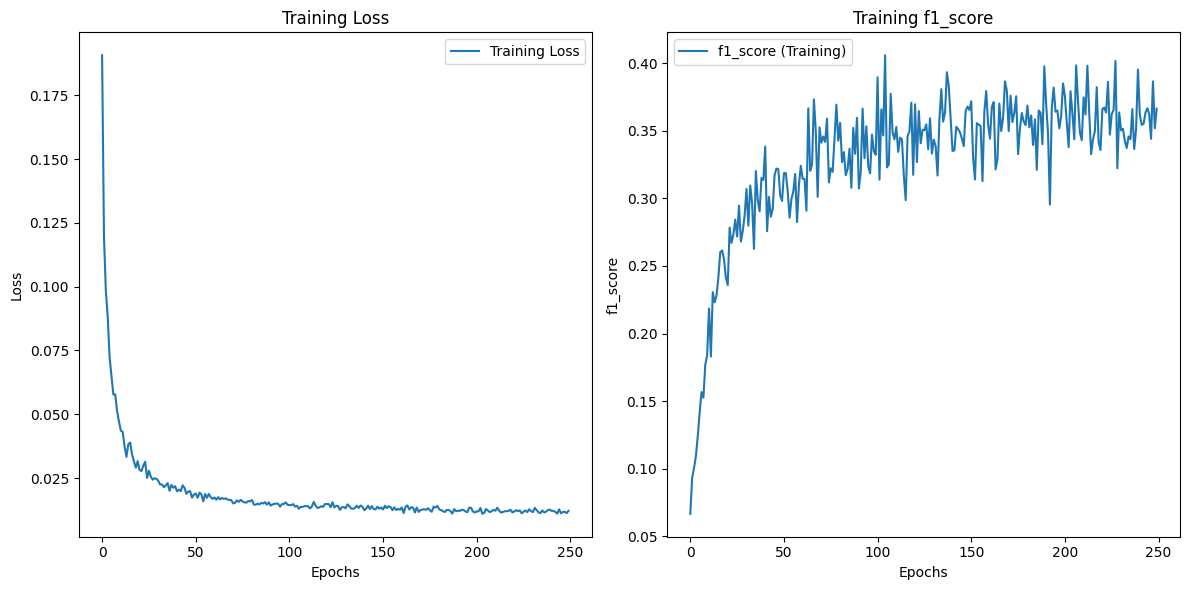

In [ ]:
plt.figure(figsize=(12, 6))

#Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='f1_score (Training)')
plt.title('Training f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.tight_layout()
plt.show()

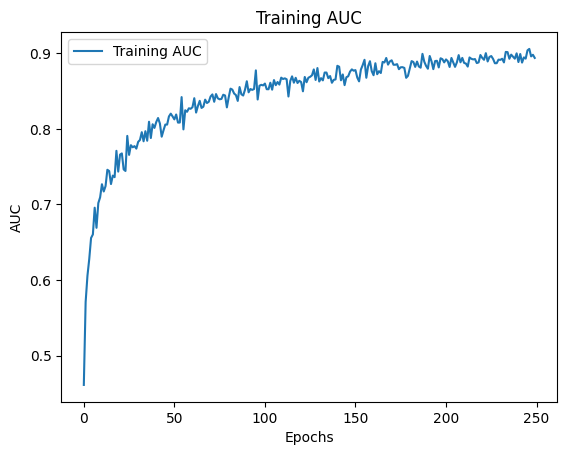

In [ ]:
plt.plot(history.history['AUC'], label='Training AUC')
plt.title('Training AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


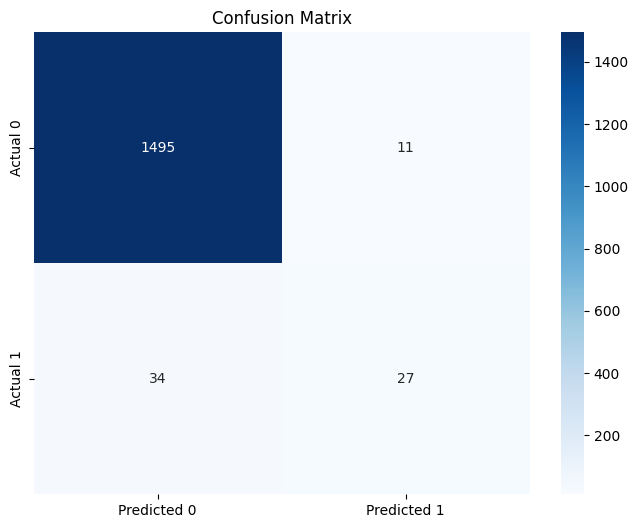

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For your neural network:
# First, convert predictions to binary (0 or 1)
y_pred = (model.predict(features_test) >= 0.5).astype(int)
y_true = task_test  # your actual test labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
val_AUC, val_f1_score, val_loss = model.evaluate(features_test, task_test, verbose = 0)

print("Val loss: ", val_loss)   #the lower the better
print("Val AUC: ", val_AUC)     #the higher the better
print("Val f1: ", val_f1_score) #the higher the better

Val loss:  0.3142856955528259
Val AUC:  0.002934131771326065
Val f1:  0.7886704206466675


# Example Usage

In [ ]:
scaler = StandardScaler()
scaler = load("scaler.pkl")
scaler

StandardScaler()

In [ ]:
print(task_data.iloc[[3000]].to_numpy())
print(task_data.iloc[[1984]].to_numpy())

print(task_data.iloc[[1987]].to_numpy())
print(task_data.iloc[[398]].to_numpy())


[[1]]
[[0]]
[[0]]
[[1]]


In [ ]:
test_input = feature_data.iloc[[3000]].to_numpy();
test_input = scaler.transform(test_input);
test_input = myPca.transform(test_input);
test_input = test_input[:,:30];
print(model.predict(test_input))

test_input = feature_data.iloc[[1984]].to_numpy();
test_input = scaler.transform(test_input);
test_input = myPca.transform(test_input);
test_input = test_input[:,:30];
print(model.predict(test_input))

test_input = feature_data.iloc[[1987]].to_numpy();
test_input = scaler.transform(test_input);
test_input = myPca.transform(test_input);
test_input = test_input[:,:30];
print(model.predict(test_input))

test_input = feature_data.iloc[[398]].to_numpy();
test_input = scaler.transform(test_input);
test_input = myPca.transform(test_input);
test_input = test_input[:,:30];
print(model.predict(test_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[[0.99815696]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.36369944]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[0.29607934]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.5965218]]
